In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import talib
import sys
import os
sys.path.append(os.path.abspath(".."))  # if you're inside notebooks/

from scripts.news_utils import (
    load_news_data,
    parse_dates,
    filter_by_ticker,
    daily_article_counts,
    plot_daily_article_frequency
)

In [4]:
ticker = 'AMZN'
news_path = '../data/raw_analyst_ratings.csv'
stock_path = f'../data/yfinance_data/{ticker}_historical_data.csv'

# ------------------ Load & Preprocess News Data ------------------
df_news = load_news_data(news_path)
df_news = parse_dates(df_news)
df_news_aapl = filter_by_ticker(df_news, ticker)

print("\nAMZN News Data Info:")
print(df_news_aapl.info())


AMZN News Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 278 entries, 76177 to 76454
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   headline   278 non-null    object             
 1   url        278 non-null    object             
 2   publisher  278 non-null    object             
 3   date       278 non-null    datetime64[ns, UTC]
 4   stock      278 non-null    object             
 5   date_only  278 non-null    object             
dtypes: datetime64[ns, UTC](1), object(5)
memory usage: 15.2+ KB
None


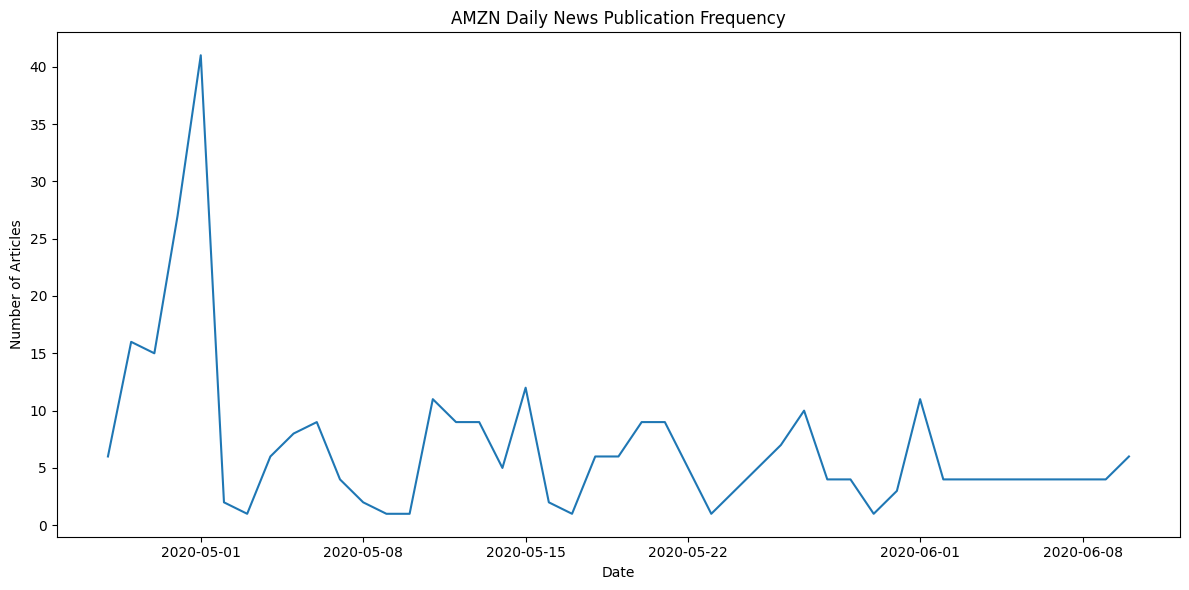


AMZN Stock Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1072 entries, 2020-04-27 to 2024-07-30
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1072 non-null   float64
 1   High          1072 non-null   float64
 2   Low           1072 non-null   float64
 3   Close         1072 non-null   float64
 4   Adj Close     1072 non-null   float64
 5   Volume        1072 non-null   int64  
 6   Dividends     1072 non-null   float64
 7   Stock Splits  1072 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 75.4 KB
None


In [7]:
# ------------------ Visualize News Frequency ------------------
daily_counts = daily_article_counts(df_news_aapl)
plot_daily_article_frequency(daily_counts, title=f'{ticker} Daily News Publication Frequency')

# ------------------ Load Stock Price Data ------------------
df_stock = pd.read_csv(stock_path)
df_news_aapl.loc[:, 'date'] = df_news_aapl['date'].apply(
    lambda x: x.tz_convert(None) if x.tzinfo else x
)

df_stock['Date'] = pd.to_datetime(df_stock['Date'])
df_stock.set_index('Date', inplace=True)
df_stock = df_stock[df_stock.index >= df_news_aapl['date'].min()]  # Align with news

print("\nAMZN Stock Data Info:")
print(df_stock.info())

In [8]:
# ------------------ Technical Indicators ------------------
df_stock['SMA_20'] = talib.SMA(df_stock['Close'], timeperiod=20)
df_stock['EMA_20'] = talib.EMA(df_stock['Close'], timeperiod=20)
df_stock['RSI'] = talib.RSI(df_stock['Close'], timeperiod=14)
df_stock['MACD'], df_stock['MACD_Signal'], df_stock['MACD_Hist'] = talib.MACD(
    df_stock['Close'], fastperiod=12, slowperiod=26, signalperiod=9
)

In [9]:
# ------------------ Financial Metrics ------------------
df_stock['Daily_Return'] = df_stock['Close'].pct_change() * 100
df_stock['Volatility'] = df_stock['Daily_Return'].rolling(window=20).std()


AAPL with Indicators and Metrics:
                 Close    SMA_20        RSI  Daily_Return      MACD  \
Date                                                                  
2024-07-24  180.830002  192.8900  37.221397     -2.993403 -1.342010   
2024-07-25  179.850006  192.2020  36.132394     -0.541943 -1.878483   
2024-07-26  182.500000  191.4345  41.146719      1.473447 -2.065994   
2024-07-29  183.199997  190.9320  42.432437      0.383560 -2.133520   
2024-07-30  181.710007  190.1575  40.408843     -0.813313 -2.280971   

            MACD_Signal  MACD_Hist  
Date                                
2024-07-24     0.635114  -1.977124  
2024-07-25     0.132395  -2.010878  
2024-07-26    -0.307283  -1.758711  
2024-07-29    -0.672530  -1.460990  
2024-07-30    -0.994218  -1.286753  


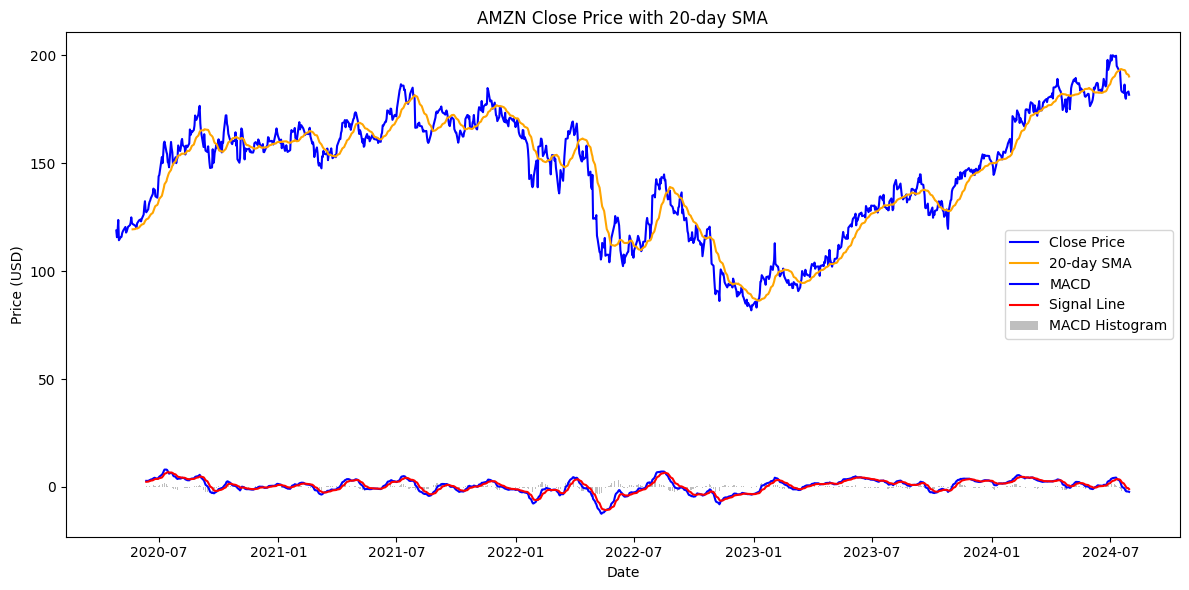

In [10]:
# ------------------ Inspect & Visualize ------------------
print("\nAAPL with Indicators and Metrics:")
print(df_stock[['Close', 'SMA_20', 'RSI', 'Daily_Return', 'MACD', 'MACD_Signal', 'MACD_Hist']].tail())


# Plot Close Price with SMA
plt.figure(figsize=(12, 6))
plt.plot(df_stock['Close'], label='Close Price', color='blue')
plt.plot(df_stock['SMA_20'], label='20-day SMA', color='orange')
plt.plot(df_stock.index, df_stock['MACD'], label='MACD', color='blue')
plt.plot(df_stock.index, df_stock['MACD_Signal'], label='Signal Line', color='red')
plt.bar(df_stock.index, df_stock['MACD_Hist'], label='MACD Histogram', color='gray', alpha=0.5)


plt.title(f'{ticker} Close Price with 20-day SMA')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()